In [31]:
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/gpiosenka/balls-image-classification')

Skipping, found downloaded files in "./balls-image-classification" (use force=True to force download)


In [32]:
import tensorflow as tf

### Importing Libraries

In [33]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob # glob (short for global) is used to return all file paths that match a specific pattern.
import keras
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense , GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from sklearn.metrics import classification_report

from PIL import Image

### Defining the train, test and validation datasets

In [34]:
base_path = 'balls-image-classification'
train_dir = 'balls-image-classification/train'
test_dir = 'balls-image-classification/test'
val_dir = 'balls-image-classification/valid'

In [35]:
df = pd.read_csv("balls-image-classification/balls.csv")
df.head()

,filepaths,labels,data set
0,train/baseball/001.jpg,baseball,train
1,train/baseball/002.jpg,baseball,train
2,train/baseball/003.jpg,baseball,train
3,train/baseball/004.jpg,baseball,train
4,train/baseball/005.jpg,baseball,train


### Finding Total Classes

In [36]:
# Total number of images 
print(f"Total number of images: {len(df)}")

Total number of images: 3311


In [37]:
# Train and Test split
count = df['data set'].value_counts()

In [38]:
print(f"Number of training images   : {count[0]}")
print(f"Number of testing images    : {count[1]}")
print(f"Number of validation images : {count[2]}")

Number of training images   : 3051
Number of testing images    : 130
Number of validation images : 130


Text(0.5, 1.0, 'Share of train, test and validation images')

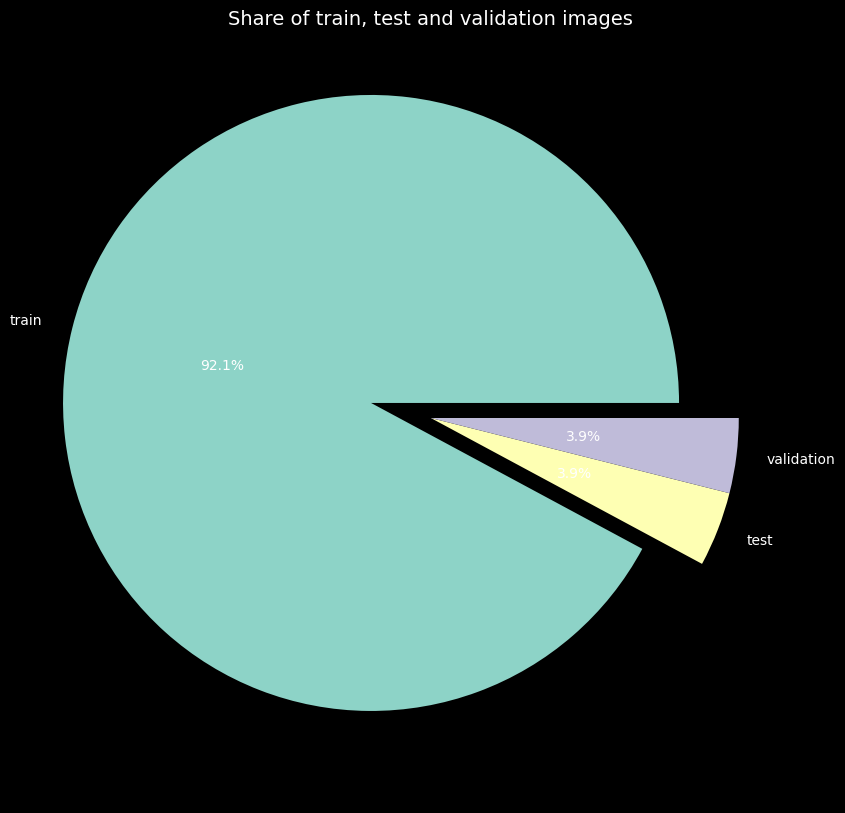

In [39]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([count[0], count[1], count[2]]), autopct="%.1f%%", explode=[0.2,0, 0], labels=["train", "test", "validation"], pctdistance=0.5)
plt.title("Share of train, test and validation images", fontsize=14)

In [40]:
NUM_CATEGORIES = os.listdir(train_dir)
len(NUM_CATEGORIES)

26

In [41]:
train_images = glob.glob(f"{train_dir}/*/*.jpg")
test_images = glob.glob(f"{test_dir}/*/*.jpg")
val_images = glob.glob(f"{val_dir}/*/*.jpg")

### Number of training images available for each class:

In [42]:
class_dict = {}
for clas in NUM_CATEGORIES:
    num_items = len(os.listdir(os.path.join(train_dir, clas)))
    class_dict[clas] = num_items

In [43]:
class_dict

{'marble': 131,
 'golf ball': 106,
 'volley ball': 131,
 'pokeman balls': 86,
 'beachballs': 92,
 'eyeballs': 139,
 'wiffle ball': 99,
 'paint balls': 32,
 'football': 112,
 'baseball': 112,
 'tennis ball': 139,
 'billiard ball': 143,
 'basketball': 116,
 'brass': 113,
 'tether ball': 105,
 'cricket ball': 150,
 'soccer ball': 167,
 'bowling ball': 145,
 'cannon ball': 183,
 'puffballs': 106,
 'wrecking ball': 69,
 'meat ball': 137,
 'medicine ball': 77,
 'screwballs': 140,
 'water polo ball': 139,
 'buckeyballs': 82}

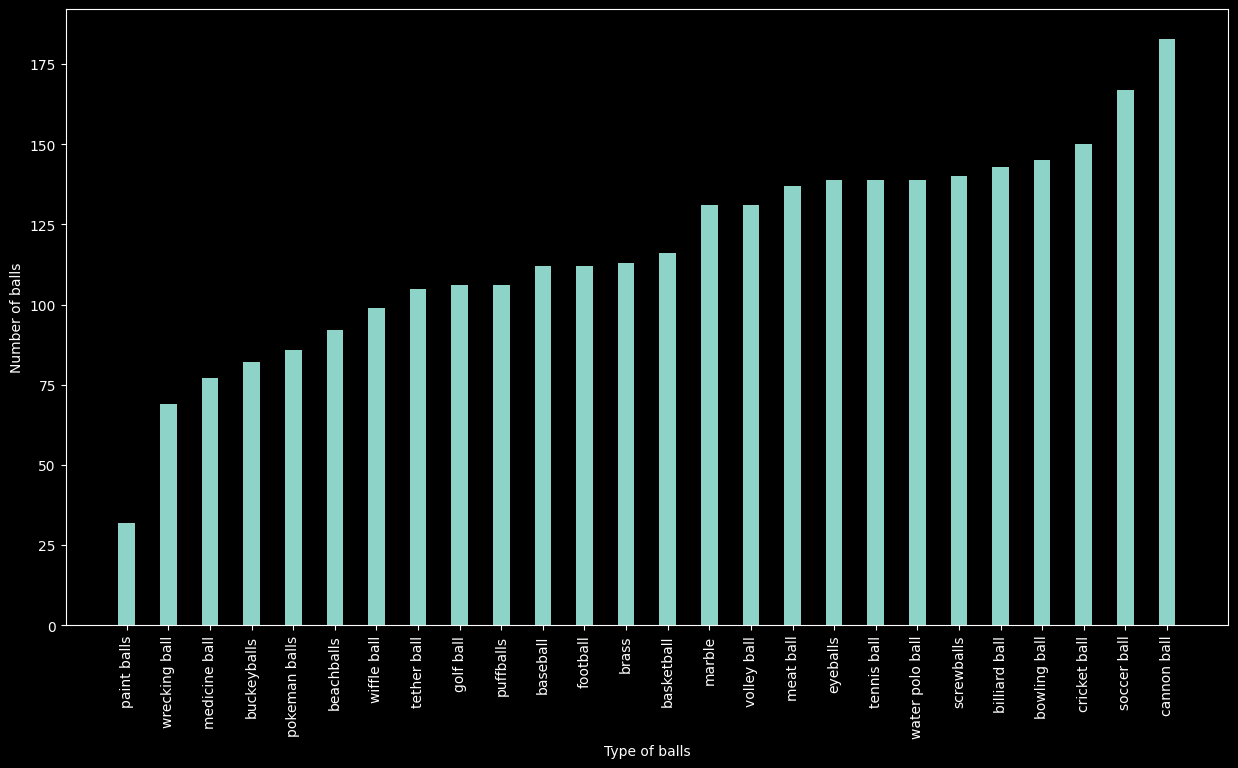

In [44]:
zipped_lists = zip(list(class_dict.values()) , list(class_dict.keys()))
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
n_count , class_number = [list(tuple) for tuple in tuples]

plt.figure(figsize=(15,8))
plt.bar(class_number , n_count , width=0.4, align="center" )
plt.xticks(rotation=90)

plt.xlabel("Type of balls")
plt.ylabel("Number of balls")
plt.show()

### Visualizing 25 random images from test data

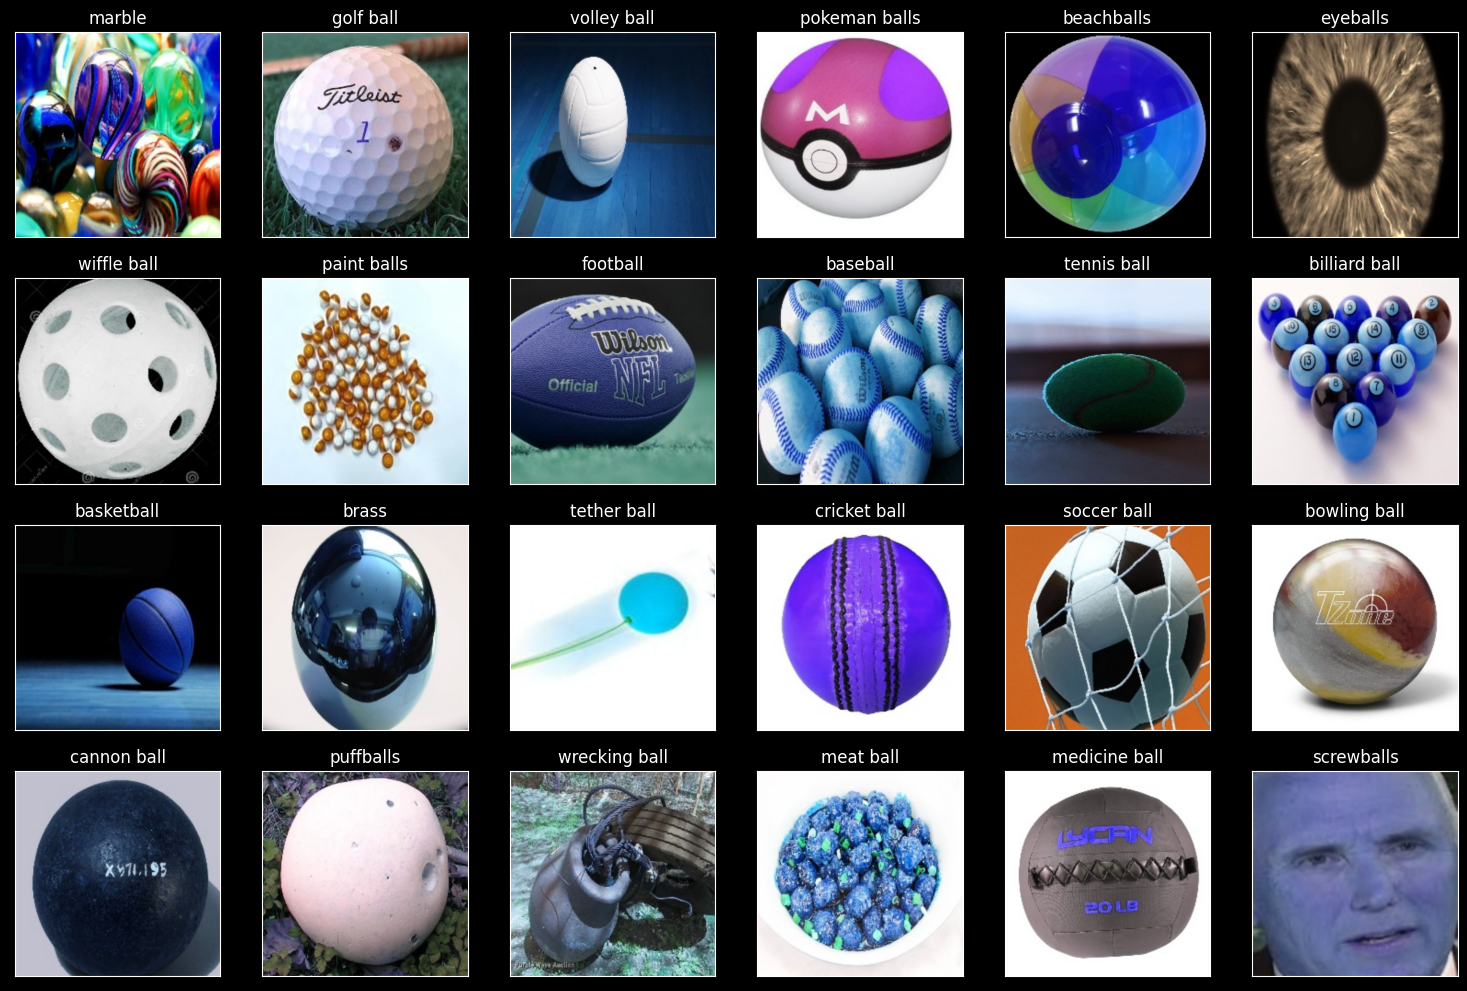

In [45]:
import random


fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i , ax in enumerate(axes.flat):
    images = os.listdir(os.path.join(train_dir , NUM_CATEGORIES[i]))
    img = cv2.imread(os.path.join(train_dir , NUM_CATEGORIES[i] , images[i]))
    img = cv2.resize(img , (512 , 512))
    ax.imshow(img)
    ax.set_title(NUM_CATEGORIES[i])
fig.tight_layout()
plt.show()    

### Collecting the data

In [46]:
IMG_HEIGHT = 220
IMG_WIDTH = 220
CHANNELS = 3

In [47]:
image_data = []
image_labels = []

for i in NUM_CATEGORIES:
    path = 'balls-image-classification/train/'
    images = os.listdir(os.path.join(path , i))
    for img in images:
        try:
            image = plt.imread(os.path.join(path , i , img))
            image_fromarray = Image.fromarray(image , 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT , IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape , image_labels.shape) 

Error in 037.jpg
Error in 103.jpg
Error in 166.jpg
Error in 078.jpg
Error in 124.jpg
Error in 142.jpg
Error in 22.jpg
Error in 073.jpg
(3043, 220, 220, 3) (3043,)


### Shuffling the training data

In [48]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train , X_val , y_train , y_val = train_test_split(image_data,
 image_labels, test_size = 0.3 , random_state = 42 , shuffle = True)

X_train = X_train / 255
X_val = X_val / 255

print('X_train.shape' , X_train.shape)
print('X_valid.shape' , X_val.shape)
print('y_train.shape' , y_train.shape)
print('y_valid.shape' , y_val.shape)

X_train.shape (2130, 220, 220, 3)
X_valid.shape (913, 220, 220, 3)
y_train.shape (2130,)
y_valid.shape (913,)


In [51]:
y_train

array(['wiffle ball', 'tennis ball', 'bowling ball', ..., 'golf ball',
       'tennis ball', 'cricket ball'], dtype='<U15')

In [52]:
NUM_CATEGORIES

['marble',
 'golf ball',
 'volley ball',
 'pokeman balls',
 'beachballs',
 'eyeballs',
 'wiffle ball',
 'paint balls',
 'football',
 'baseball',
 'tennis ball',
 'billiard ball',
 'basketball',
 'brass',
 'tether ball',
 'cricket ball',
 'soccer ball',
 'bowling ball',
 'cannon ball',
 'puffballs',
 'wrecking ball',
 'meat ball',
 'medicine ball',
 'screwballs',
 'water polo ball',
 'buckeyballs']

In [53]:
y_train.shape

(2130,)

In [54]:
y_val.shape

(913,)

In [55]:
y_train_one_hot = pd.get_dummies(y_train)
y_val_one_hot = pd.get_dummies(y_val)

y_train_one_hot.shape , y_val_one_hot.shape

((2130, 26), (913, 26))

### Model Creation


In [57]:
model = keras.models.Sequential([
    layers.Conv2D(filters = 16 , kernel_size = (3 , 3) , activation = 'relu', input_shape = (220 , 220 , 3)),
    layers.Conv2D(filters = 32 , kernel_size = (3, 3) , activation = 'relu'),
    layers.MaxPool2D(pool_size = (2 , 2)),
    layers.BatchNormalization(axis = -1),
    layers.Conv2D(filters = 64, kernel_size = (3 , 3) , activation = 'relu'),
    layers.Conv2D(filters = 128 , kernel_size = (3 , 3) , activation = 'relu'),
    layers.MaxPool2D(pool_size = (2 , 2)),
    layers.BatchNormalization(axis = -1),

    layers.Flatten(),
    layers.Dense(512 , activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.2),
    layers.Dense(26, activation='softmax')
])

In [60]:
input_shape = (220 , 220 , 3)

In [69]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(layers.Conv2D(filters = 16 , kernel_size = (3 , 3) , activation = 'relu', input_shape = (220 , 220 , 3)))
model.add(layers.Conv2D(filters = 32 , kernel_size = (3, 3) , activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2 , 2)))
model.add(layers.BatchNormalization(axis = -1))

model.add(layers.Flatten())
model.add(layers.Dense(512 , activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.2))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_18 (Conv2D)          (None, 5, 5, 16)          184336    
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization_11 (Bat  (None, 1, 1, 32)         128       
 chNormalization)                                                
                                                      

### Model Training

In [70]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (220, 220))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=20, class_mode = 'categorical', target_size=(220, 220))
test_generator = test_datagen.flow_from_directory(test_dir,shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(220, 220))

Found 3051 images belonging to 26 classes.
Found 130 images belonging to 26 classes.
Found 130 images belonging to 26 classes.


In [72]:
lr = 0.001
epochs = 30

opt = Adam(lr = lr, decay = lr / (epochs * 0.5))
model.compile(loss = 'categorical_crossentropy' , optimizer = opt,
metrics = ['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = 100, epochs = 30, callbacks = callback)

Epoch 1/30
100/100 [==============================] - 23s 211ms/step - loss: 0.7512 - accuracy: 0.7775 - val_loss: 0.6781 - val_accuracy: 0.7692
Epoch 2/30
100/100 [==============================] - 21s 213ms/step - loss: 0.5076 - accuracy: 0.8488 - val_loss: 0.5301 - val_accuracy: 0.8385
Epoch 3/30
100/100 [==============================] - 22s 224ms/step - loss: 0.4627 - accuracy: 0.8669 - val_loss: 0.2825 - val_accuracy: 0.9154
Epoch 4/30
100/100 [==============================] - 22s 223ms/step - loss: 0.3421 - accuracy: 0.8975 - val_loss: 0.2627 - val_accuracy: 0.8923
Epoch 5/30
100/100 [==============================] - 23s 226ms/step - loss: 0.2824 - accuracy: 0.9056 - val_loss: 0.4496 - val_accuracy: 0.8615
Epoch 6/30
100/100 [==============================] - 23s 227ms/step - loss: 0.2616 - accuracy: 0.9252 - val_loss: 0.2506 - val_accuracy: 0.9077
Epoch 7/30
100/100 [==============================] - 23s 230ms/step - loss: 0.3055 - accuracy: 0.9076 - val_loss: 0.3538 - val_ac

### Saving the model

In [73]:
# Save a model
model.save("Saved_Model")

INFO:tensorflow:Assets written to: Saved_Model/assets


INFO:tensorflow:Assets written to: Saved_Model/assets


In [74]:
# Load in a trained model and evaluate it
model_Saved = tf.keras.models.load_model("Saved_Model")
model_Saved

In [75]:
model_Saved.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_18 (Conv2D)          (None, 5, 5, 16)          184336    
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization_11 (Bat  (None, 1, 1, 32)         128       
 chNormalization)                                                
                                                      

### Metrics

In [76]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

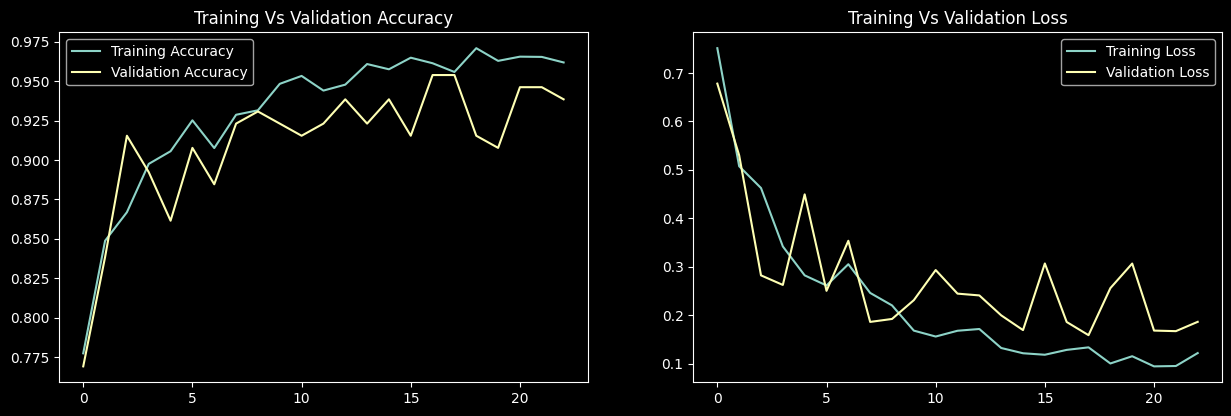

In [77]:
plt.figure(figsize = (15 , 10))

plt.subplot(2, 2, 1)
plt.plot(accuracy , label = "Training Accuracy")
plt.plot(val_accuracy , label = 'Validation Accuracy')
plt.legend()
plt.title("Training Vs Validation Accuracy")

plt.subplot(2, 2, 2)
plt.plot(loss , label = 'Training Loss')
plt.plot(val_loss , label = 'Validation Loss')
plt.legend()
plt.title("Training Vs Validation Loss")

plt.show()

In [85]:
preds = model.predict(test_generator)
preds

7/7 [==============================] - 1s 134ms/step


array([[9.9998391e-01, 2.6598329e-07, 3.4518326e-09, ..., 2.1465166e-08,
        4.1358402e-07, 9.4418539e-08],
       [9.9963582e-01, 4.7187509e-06, 8.4255703e-08, ..., 7.7275394e-07,
        2.3128829e-05, 3.5887015e-07],
       [9.9997222e-01, 6.5454304e-07, 1.3005904e-11, ..., 4.3790740e-09,
        3.4976204e-09, 1.1167043e-06],
       ...,
       [1.6305499e-08, 9.4823590e-05, 5.8354771e-10, ..., 3.6051745e-07,
        2.1141682e-09, 9.9418736e-01],
       [1.9482638e-10, 2.4132853e-06, 4.7004805e-13, ..., 5.5775345e-12,
        7.7077109e-13, 9.9987328e-01],
       [2.8912878e-10, 1.1055458e-06, 2.2016972e-12, ..., 7.2818090e-10,
        2.4015274e-11, 9.9983644e-01]], dtype=float32)

In [86]:
y_pred = np.argmax(preds, axis = 1)

In [87]:
y_pred_class = dict((v , k) for k , v in test_generator.class_indices.items())

In [88]:
y_pred_class

{0: 'baseball',
 1: 'basketball',
 2: 'beachballs',
 3: 'billiard ball',
 4: 'bowling ball',
 5: 'brass',
 6: 'buckeyballs',
 7: 'cannon ball',
 8: 'cricket ball',
 9: 'eyeballs',
 10: 'football',
 11: 'golf ball',
 12: 'marble',
 13: 'meat ball',
 14: 'medicine ball',
 15: 'paint balls',
 16: 'pokeman balls',
 17: 'puffballs',
 18: 'screwballs',
 19: 'soccer ball',
 20: 'tennis ball',
 21: 'tether ball',
 22: 'volley ball',
 23: 'water polo ball',
 24: 'wiffle ball',
 25: 'wrecking ball'}

In [89]:
y_pred

array([ 0,  0,  0,  0,  0,  1,  1,  1, 10,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5, 16,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12,  3, 12, 13, 13, 13,
        7, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16,  4, 16, 16, 16,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 23, 22, 22, 22, 22, 23, 23,  1,
       23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25])

In [90]:
y_pred = list(map(lambda x : y_pred_class[x] , y_pred))

In [91]:
y_pred

['baseball',
 'baseball',
 'baseball',
 'baseball',
 'baseball',
 'basketball',
 'basketball',
 'basketball',
 'football',
 'basketball',
 'beachballs',
 'beachballs',
 'beachballs',
 'beachballs',
 'beachballs',
 'billiard ball',
 'billiard ball',
 'billiard ball',
 'billiard ball',
 'billiard ball',
 'bowling ball',
 'bowling ball',
 'bowling ball',
 'bowling ball',
 'bowling ball',
 'brass',
 'brass',
 'brass',
 'brass',
 'pokeman balls',
 'buckeyballs',
 'buckeyballs',
 'buckeyballs',
 'buckeyballs',
 'buckeyballs',
 'cannon ball',
 'cannon ball',
 'cannon ball',
 'cannon ball',
 'cannon ball',
 'cricket ball',
 'cricket ball',
 'cricket ball',
 'cricket ball',
 'cricket ball',
 'eyeballs',
 'eyeballs',
 'eyeballs',
 'eyeballs',
 'eyeballs',
 'football',
 'football',
 'football',
 'football',
 'football',
 'golf ball',
 'golf ball',
 'golf ball',
 'golf ball',
 'golf ball',
 'marble',
 'marble',
 'marble',
 'billiard ball',
 'marble',
 'meat ball',
 'meat ball',
 'meat ball',
 'can

In [92]:
y_true = test_generator.classes

In [93]:
y_true = list(map(lambda x: y_pred_class[x] , y_true))

In [96]:
print(classification_report(y_true , y_pred))

                 precision    recall  f1-score   support

       baseball       1.00      1.00      1.00         5
     basketball       0.80      0.80      0.80         5
     beachballs       1.00      1.00      1.00         5
  billiard ball       0.83      1.00      0.91         5
   bowling ball       0.83      1.00      0.91         5
          brass       1.00      0.80      0.89         5
    buckeyballs       1.00      1.00      1.00         5
    cannon ball       0.83      1.00      0.91         5
   cricket ball       1.00      1.00      1.00         5
       eyeballs       1.00      1.00      1.00         5
       football       0.83      1.00      0.91         5
      golf ball       1.00      1.00      1.00         5
         marble       1.00      0.80      0.89         5
      meat ball       1.00      0.80      0.89         5
  medicine ball       1.00      1.00      1.00         5
    paint balls       1.00      1.00      1.00         5
  pokeman balls       0.80    

In [95]:
results = model.evaluate(test_generator)

7/7 [==============================] - 1s 141ms/step - loss: 0.1713 - accuracy: 0.9385
